In [1]:
!pip install pandas numpy scikit-learn

In [12]:
import random
from datetime import datetime, timedelta
import pandas as pd

def generate_synthetic_logs(num_logs: int, filename: str):
    """Generate synthetic logs with frequent error patterns."""
    log_levels = ['INFO', 'WARNING', 'ERROR']
    messages = [
        "Database connection timeout",
        "High CPU usage detected",
        "User login successful",
        "Failed to process request ID <UUID>",
        "Disk space low on server <IP>",
        "API response time exceeded <NUM>ms",
        "Authentication failure for user <USER>",
        "Server <IP> restarted successfully",
        "Memory leak detected in module <NUM>",
        "Connection timeout"
    ]
    weights = [0.3, 0.2, 0.1, 0.05, 0.1, 0.05, 0.2, 0.05, 0.05, 0.3]  # Favor errors
    start_time = datetime(2025, 7, 8, 12, 0, 0)

    logs = []
    for i in range(num_logs):
        timestamp = start_time + timedelta(seconds=i)
        level = random.choices(log_levels, weights=[0.4, 0.3, 0.3])[0]
        message_template = random.choices(messages, weights=weights)[0]
        message = message_template.replace('<UUID>', f"{random.randint(1000, 9999)}-{random.randint(1000, 9999)}")
        message = message.replace('<IP>', f"192.168.1.{random.randint(1, 255)}")
        message = message.replace('<NUM>', str(random.randint(100, 500)))
        message = message.replace('<USER>', f"user{random.randint(1, 100)}")
        log_line = f"{timestamp.strftime('%Y-%m-%d %H:%M:%S')} {level} {message}"
        logs.append(log_line)

    # Add repeated error logs to trigger alerts
    error_messages = ["Database connection timeout", "Authentication failure for user <USER>", "Connection timeout", "Memory leak detected in module <NUM>"]
    for i in range(num_logs // 4):
        timestamp = start_time + timedelta(seconds=num_logs + i)
        message_template = random.choice(error_messages)
        message = message_template.replace('<USER>', f"user{random.randint(1, 100)}")
        message = message.replace('<NUM>', str(random.randint(100, 500)))
        log_line = f"{timestamp.strftime('%Y-%m-%d %H:%M:%S')} ERROR {message}"
        logs.append(log_line)

    # Save to file
    with open(filename, 'w') as f:
        for log in logs:
            f.write(log + '\n')

    return logs

# Generate 1500 synthetic logs
generate_synthetic_logs(1500, 'logs.txt')
print("Generated logs.txt with 1500 synthetic logs")

Generated logs.txt with 1500 synthetic logs


In [18]:
import re
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
from collections import defaultdict
import logging
import json
from typing import Dict, List, Tuple
import threading
import queue

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class LogIngestion:
    """Handles log collection and preprocessing"""
    def __init__(self):
        self.log_queue = queue.Queue()
        self.supported_formats = [
            r'(?P<timestamp>\d{4}-\d{2}-\d{2}\s+\d{2}:\d{2}:\d{2})\s+(?P<level>\w+)\s+(?P<message>.+)',
            r'\[(?P<timestamp>\d{4}-\d{2}-\d{2}\s+\d{2}:\d{2}:\d{2}\.\d+)\]\s+(?P<level>\w+)\:\s+(?P<message>.+)'
        ]
        self.parsed_count = 0
        self.all_logs = []

    def parse_log(self, log_line: str) -> Dict:
        """Parse a single log line into structured format"""
        for pattern in self.supported_formats:
            match = re.match(pattern, log_line.strip())
            if match:
                return match.groupdict()
        logger.warning(f"Failed to parse log line: {log_line}")
        return None

    def ingest_log(self, log_line: str):
        """Ingest a log line and add to queue"""
        parsed_log = self.parse_log(log_line)
        if parsed_log:
            try:
                parsed_log['timestamp'] = pd.to_datetime(parsed_log['timestamp'])
                self.parsed_count += 1
                self.log_queue.put(parsed_log)
                self.all_logs.append(parsed_log)
            except ValueError as e:
                logger.error(f"Could not parse timestamp in log: {parsed_log['timestamp']}, Error: {e}")
                return None
        return parsed_log

class PatternRecognition:
    """Identifies recurring patterns in logs"""
    def __init__(self):
        self.patterns = defaultdict(list)
        self.pattern_counter = defaultdict(int)

    def normalize_message(self, message: str) -> str:
        """Normalize log message by replacing dynamic parts"""
        message = re.sub(r'\d+\.\d+\.\d+\.\d+', '<IP>', message)
        message = re.sub(r'\b[0-9a-f]{4}-[0-9a-f]{4}\b', '<UUID>', message)
        message = re.sub(r'\d+', '<NUM>', message)
        message = re.sub(r'user\d+', '<USER>', message)
        return message

    def add_pattern(self, log: Dict):
        """Add log to pattern tracking"""
        if not log:
            return
        normalized = self.normalize_message(log['message'])
        self.patterns[normalized].append(log)
        self.pattern_counter[normalized] += 1

    def get_frequent_patterns(self, min_count: int = 5) -> List[Tuple[str, int]]:
        """Return patterns that appear at least min_count times"""
        return [(pattern, count) for pattern, count in self.pattern_counter.items() if count >= min_count]

class AnomalyDetector:
    """Detects anomalies in log patterns using Isolation Forest"""
    def __init__(self, contamination: float = 0.005):
        self.model = IsolationForest(contamination=contamination, random_state=42)
        self.scaler = StandardScaler()
        self.pattern_history = []
        self.is_trained = False

    def extract_features(self, logs: List[Dict], pattern_counter: defaultdict) -> np.ndarray:
        """Extract features from logs for anomaly detection"""
        features = []
        min_timestamp = min(log['timestamp'] for log in logs).timestamp() if logs else 0
        for log in logs:
            normalized = PatternRecognition().normalize_message(log['message'])
            log_level_score = {'ERROR': 2, 'WARNING': 1, 'INFO': 0}.get(log['level'], 0)
            feature_vector = [
                (log['timestamp'].timestamp() - min_timestamp) / 60,
                len(log['message']),
                log_level_score,
                pattern_counter[normalized] / max(pattern_counter.values() or [1])
            ]
            features.append(feature_vector)
        return np.array(features)

    def train(self, logs: List[Dict], pattern_counter: defaultdict):
        """Train the anomaly detection model"""
        if not logs:
            return
        features = self.extract_features(logs, pattern_counter)
        if features.shape[0] > 10:
            features_scaled = self.scaler.fit_transform(features)
            self.model.fit(features_scaled)
            self.pattern_history.extend(features_scaled)
            self.is_trained = True
            logger.debug(f"Trained model with {features.shape[0]} samples, features: {features[0]}")
        else:
            logger.debug(f"Skipped training, only {features.shape[0]} samples")

    def detect_anomalies(self, logs: List[Dict], pattern_counter: defaultdict) -> List[bool]:
        """Detect anomalies in new logs"""
        if not logs:
            logger.debug("No logs provided for anomaly detection")
            return []
        if not self.is_trained:
            logger.debug("Model not trained, using rule-based anomaly detection")
            return [log['level'] in ['ERROR', 'WARNING'] for log in logs]
        features = self.extract_features(logs, pattern_counter)
        if features.shape[0] == 0:
            logger.debug("No features extracted for anomaly detection")
            return [False] * len(logs)
        features_scaled = self.scaler.transform(features)
        predictions = self.model.predict(features_scaled)
        anomalies = [pred == -1 for pred in predictions]
        for i, log in enumerate(logs):
            if log['level'] in ['ERROR', 'WARNING'] and not anomalies[i]:
                anomalies[i] = True
                logger.debug(f"Rule-based anomaly: {log['message']}")
        logger.debug(f"Anomaly predictions: {sum(anomalies)} anomalies in {len(anomalies)} logs")
        return anomalies

class IncidentPredictor:
    """Predicts potential incidents based on anomalies and patterns"""
    def __init__(self, anomaly_detector: AnomalyDetector):
        self.anomaly_detector = anomaly_detector
        self.incident_threshold = 1
        self.recent_anomalies = defaultdict(list)

    def predict_incident(self, logs: List[Dict], patterns: List[Tuple[str, int]], pattern_counter: defaultdict) -> List[Dict]:
        """Predict potential incidents"""
        anomalies = self.anomaly_detector.detect_anomalies(logs, pattern_counter)
        incidents = []
        for log, is_anomaly in zip(logs, anomalies):
            if is_anomaly:
                normalized_msg = PatternRecognition().normalize_message(log['message'])
                self.recent_anomalies[normalized_msg].append(log)
                if len(self.recent_anomalies[normalized_msg]) >= self.incident_threshold:
                    incidents.append({
                        'timestamp': log['timestamp'],
                        'message': log['message'],
                        'pattern': normalized_msg,
                        'severity': 'HIGH' if log['level'] == 'ERROR' else 'MEDIUM',
                        'confidence': min(len(self.recent_anomalies[normalized_msg]) / self.incident_threshold, 1.0)
                    })
        logger.debug(f"Generated {len(incidents)} incidents from {sum(anomalies)} anomalies")
        return incidents

class AlertSystem:
    """Handles alerting for predicted incidents"""
    def __init__(self):
        self.alerts = []

    def generate_alert(self, incident: Dict):
        """Generate and store alert for an incident"""
        alert = {
            'timestamp': incident['timestamp'],
            'message': f"Potential incident detected: {incident['message']}",
            'severity': incident['severity'],
            'confidence': incident['confidence'],
            'context': {
                'pattern': incident['pattern'],
                'original_log': incident['message']
            }
        }
        self.alerts.append(alert)
        logger.warning(f"ALERT: {alert['message']} (Severity: {alert['severity']}, Confidence: {alert['confidence']:.2f})")
        return alert

    def get_alerts(self) -> List[Dict]:
        """Return all generated alerts"""
        return self.alerts

class LogAnalysisSystem:
    """Main system orchestrating all components"""
    def __init__(self):
        self.ingestion = LogIngestion()
        self.pattern_recognition = PatternRecognition()
        self.anomaly_detector = AnomalyDetector()
        self.incident_predictor = IncidentPredictor(self.anomaly_detector)
        self.alert_system = AlertSystem()
        self.process_thread = None
        self.running = False
        self.anomaly_labels = []

    def process_logs(self):
        """Process logs from queue in a separate thread"""
        if self.ingestion.all_logs and not self.anomaly_detector.is_trained:
            self.anomaly_detector.train(self.ingestion.all_logs, self.pattern_recognition.pattern_counter)
            logger.info(f"Initial training on {len(self.ingestion.all_logs)} logs")

        while self.running:
            try:
                log = self.ingestion.log_queue.get(timeout=1.0)
                if log:
                    self.pattern_recognition.add_pattern(log)
                    is_anomaly = self.anomaly_detector.detect_anomalies([log], self.pattern_recognition.pattern_counter)[0]
                    self.anomaly_labels.append((log, is_anomaly))
                    incidents = self.incident_predictor.predict_incident(
                        [log], self.pattern_recognition.get_frequent_patterns(),
                        self.pattern_recognition.pattern_counter
                    )
                    for incident in incidents:
                        self.alert_system.generate_alert(incident)
                    self.ingestion.log_queue.task_done()
            except queue.Empty:
                continue
            except Exception as e:
                logger.error(f"Error processing log: {e}")
                if log and 'message' in log:
                    logger.error(f"Problematic log message: {log['message']}")
                if not self.ingestion.log_queue.empty():
                    self.ingestion.log_queue.task_done()

    def start(self):
        """Start the log analysis system"""
        self.running = True
        self.process_thread = threading.Thread(target=self.process_logs)
        self.process_thread.start()
        logger.info("Log Analysis System started")

    def stop(self):
        """Stop the log analysis system"""
        self.running = False
        if self.process_thread:
            self.process_thread.join()
        logger.info("Log Analysis System stopped")

    def ingest_log(self, log_line: str):
        """Ingest a new log line"""
        return self.ingestion.ingest_log(log_line)

    def get_alerts(self) -> List[Dict]:
        """Get all generated alerts"""
        return self.alert_system.get_alerts()

    def compute_accuracy(self) -> Dict:
        """Compute accuracy, precision, recall based on ERROR logs as ground truth"""
        if not self.anomaly_labels:
            return {"accuracy": 0, "precision": 0, "recall": 0, "tp": 0, "tn": 0, "fp": 0, "fn": 0}

        tp = sum(1 for log, is_anomaly in self.anomaly_labels if is_anomaly and log['level'] == 'ERROR')
        tn = sum(1 for log, is_anomaly in self.anomaly_labels if not is_anomaly and log['level'] != 'ERROR')
        fp = sum(1 for log, is_anomaly in self.anomaly_labels if is_anomaly and log['level'] != 'ERROR')
        fn = sum(1 for log, is_anomaly in self.anomaly_labels if not is_anomaly and log['level'] == 'ERROR')

        total = tp + tn + fp + fn
        accuracy = (tp + tn) / total if total > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0

        return {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "tp": tp,
            "tn": tn,
            "fp": fp,
            "fn": fn
        }

if __name__ == "__main__":
    # Ensure the system is stopped before re-initializing
    if 'system' in locals() and system.running:
        system.stop()

    system = LogAnalysisSystem()
    system.start()

    # Read synthetic logs from file
    with open("logs.txt", "r") as file:
        for line in file:
            system.ingest_log(line.strip())

    # Wait for processing
    import time
    time.sleep(40)

    # Debugging: Log parsed count
    print(f"Total logs parsed: {system.ingestion.parsed_count}")

    # Get and print alerts
    alerts = system.get_alerts()
    for alert in alerts:
        print(json.dumps(alert, default=str, indent=2))

    # Print summary
    print("\nFrequent Patterns Detected:")
    frequent_patterns = system.pattern_recognition.get_frequent_patterns(min_count=5)
    for pattern, count in frequent_patterns:
        print(f"Pattern: {pattern}, Count: {count}")

    print("\nTotal Alerts Generated:", len(system.get_alerts()))

    # Compute and print accuracy
    metrics = system.compute_accuracy()
    print("\nAnomaly Detection Metrics:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"True Positives (TP): {metrics['tp']}")
    print(f"True Negatives (TN): {metrics['tn']}")
    print(f"False Positives (FP): {metrics['fp']}")
    print(f"False Negatives (FN): {metrics['fn']}")

    system.stop()

Total logs parsed: 1875
{
  "timestamp": "2025-07-08 12:00:02",
  "message": "Potential incident detected: Connection timeout",
  "severity": "HIGH",
  "confidence": 1.0,
  "context": {
    "pattern": "Connection timeout",
    "original_log": "Connection timeout"
  }
}
{
  "timestamp": "2025-07-08 12:00:03",
  "message": "Potential incident detected: Connection timeout",
  "severity": "MEDIUM",
  "confidence": 1.0,
  "context": {
    "pattern": "Connection timeout",
    "original_log": "Connection timeout"
  }
}
{
  "timestamp": "2025-07-08 12:00:04",
  "message": "Potential incident detected: Connection timeout",
  "severity": "HIGH",
  "confidence": 1.0,
  "context": {
    "pattern": "Connection timeout",
    "original_log": "Connection timeout"
  }
}
{
  "timestamp": "2025-07-08 12:00:06",
  "message": "Potential incident detected: Authentication failure for user user45",
  "severity": "MEDIUM",
  "confidence": 1.0,
  "context": {
    "pattern": "Authentication failure for user user

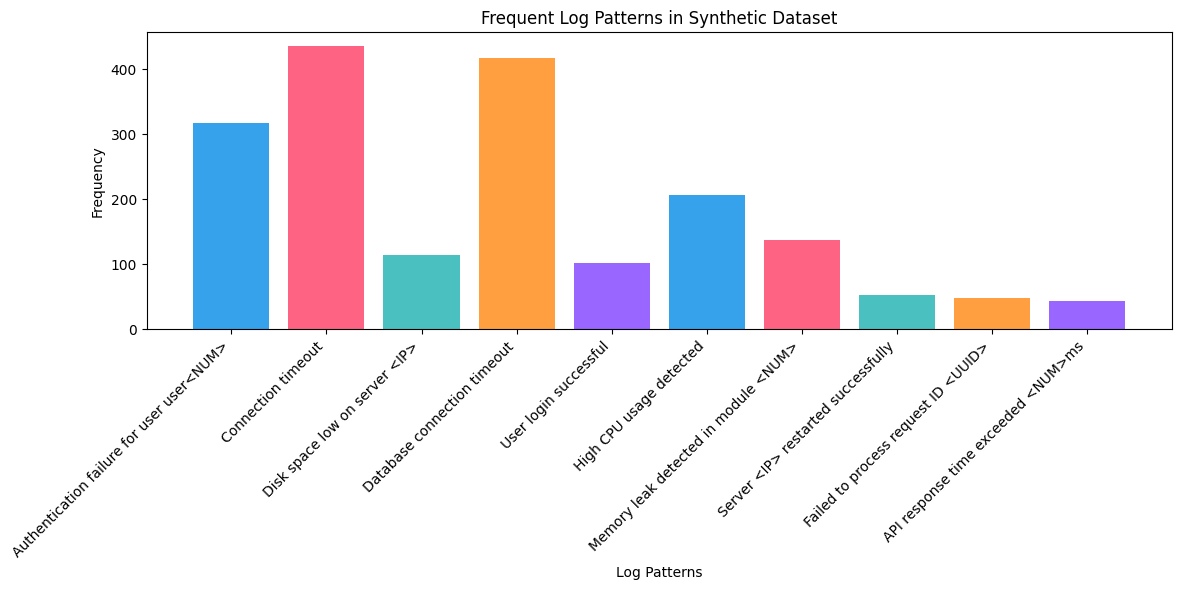

Total anomalies detected: 1285
First few anomalies: [Timestamp('2025-07-08 12:00:02'), Timestamp('2025-07-08 12:00:03'), Timestamp('2025-07-08 12:00:04'), Timestamp('2025-07-08 12:00:06'), Timestamp('2025-07-08 12:00:07')]
Error generating time-series chart: Can only use .dt accessor with datetimelike values


In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Bar chart for frequent patterns
frequent_patterns = system.pattern_recognition.get_frequent_patterns(min_count=5)
pattern_names = [pattern for pattern, _ in frequent_patterns]
pattern_counts = [count for _, count in frequent_patterns]

if not pattern_names:
    print("No frequent patterns found with min_count=5")
else:
    plt.figure(figsize=(12, 6))
    plt.bar(pattern_names, pattern_counts, color=['#36A2EB', '#FF6384', '#4BC0C0', '#FF9F40', '#9966FF'])
    plt.xlabel('Log Patterns')
    plt.ylabel('Frequency')
    plt.title('Frequent Log Patterns in Synthetic Dataset')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Time-series chart for anomalies (TP, FP, FN)
anomalies = [log['timestamp'] for log, is_anomaly in system.anomaly_labels if is_anomaly]
true_positives = [log['timestamp'] for log, is_anomaly in system.anomaly_labels if is_anomaly and log['level'] == 'ERROR']
false_positives = [log['timestamp'] for log, is_anomaly in system.anomaly_labels if is_anomaly and log['level'] != 'ERROR']
false_negatives = [log['timestamp'] for log, is_anomaly in system.anomaly_labels if not is_anomaly and log['level'] == 'ERROR']

# Debugging: Inspect anomalies
print(f"Total anomalies detected: {len(anomalies)}")
if anomalies:
    print(f"First few anomalies: {anomalies[:5]}")

if not anomalies:
    print("No anomalies detected for time-series chart")
else:
    try:
        tp_series = pd.Series(true_positives).dt.floor('min').value_counts().sort_index()
        fp_series = pd.Series(false_positives).dt.floor('min').value_counts().sort_index()
        fn_series = pd.Series(false_negatives).dt.floor('min').value_counts().sort_index()

        all_times = sorted(set(tp_series.index) | set(fp_series.index) | set(fn_series.index))
        tp_counts = [tp_series.get(t, 0) for t in all_times]
        fp_counts = [fp_series.get(t, 0) for t in all_times]
        fn_counts = [fn_series.get(t, 0) for t in all_times]

        plt.figure(figsize=(12, 6))
        plt.plot(all_times, tp_counts, label='True Positives', color='#4BC0C0')
        plt.plot(all_times, fp_counts, label='False Positives', color='#FF6384')
        plt.plot(all_times, fn_counts, label='False Negatives', color='#FF9F40')
        plt.xlabel('Time')
        plt.ylabel('Number of Anomalies')
        plt.title('Anomaly Detection Metrics Over Time (TP, FP, FN)')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error generating time-series chart: {e}")